In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
wifistats_df = pd.read_csv("./data/wifistats.csv")
extra_info_df = pd.read_csv("./data/extra_info.csv")
devices_df = pd.read_csv("./data/devices.csv")
df = pd.merge(wifistats_df, extra_info_df, on="label", how="inner")
df.head()

,label,time,signal (dBm),packet_loss,connected_time (s),tx_bitrate (MBit/s),rx_bitrate (MBit/s),min_ping_rtt (ms),avg_ping_rtt (ms),max_ping_rtt (ms),mdev_ping_rtt (ms),latitude,longitude
0,raspi-e4:5f:01:84:8c:99,2024-02-13 00:46:21.750007,-65.0,0.0,546569.0,200.0,150.0,3.308,3.878,4.840,0.572,34.413869,-119.841237
1,raspi-e4:5f:01:84:8c:99,2024-02-13 00:56:37.584578,-66.0,0.0,547196.0,200.0,150.0,3.474,5.106,6.327,0.999,34.413869,-119.841237
2,raspi-e4:5f:01:84:8c:99,2024-02-13 01:07:13.715263,-67.0,0.0,547813.0,200.0,150.0,3.801,4.473,5.712,0.683,34.413869,-119.841237
3,raspi-e4:5f:01:84:8c:99,2024-02-13 01:17:39.679114,-67.0,0.0,548450.0,200.0,121.5,4.044,4.276,4.511,0.150,34.413869,-119.841237
4,raspi-e4:5f:01:84:8c:99,2024-02-13 01:28:05.725746,-66.0,0.0,549078.0,180.0,121.5,3.442,4.189,5.267,0.793,34.413869,-119.841237


# Cory's code:

In [4]:
def plot_within_hour(df, year, month, day, hour, metric, devices):
    """
    Plots the specified metric over the specified hour for the given devices.
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data. Must include 'time', 'label', and the specified metric columns.
    - year (int): The year of the hour to plot.
    - month (int): The month of the hour to plot.
    - day (int): The day of the hour to plot.
    - hour (int): The hour (in 24-hour format) to plot.
    - metric (str): The name of the metric column to plot (e.g., 'signal', 'tx_bitrate').
    - devices (list of str): The list of device labels to include in the plot.
    Returns:
    - None: Displays the plot.
    Raises:
    - ValueError: If any device in 'devices' is not found in the DataFrame.
    - ValueError: If the 'metric' is not present in the DataFrame.
    """

    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])
    # Check if all devices are present in the DataFrame
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )

    # Filter for the specified devices
    df_filtered = df[df["label"].isin(devices)]
    # Create a datetime range for the specified hour
    start_time = pd.Timestamp(year, month, day, hour)
    end_time = start_time + pd.Timedelta(hours=1)
    # Filter the DataFrame for the specified hour
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return
    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")

    # Handle missing values in the metric column
    df_filtered = df_filtered.dropna(subset=[metric])

    # Plot the data
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=df_filtered, x="time", y=metric, hue="label", marker="o")
    # Set plot title and labels
    plt.title(f"{metric} over time on {year}-{month:02d}-{day:02d} Hour {hour:02d}")
    plt.xlabel("Time")
    plt.ylabel(metric.capitalize())
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    # Move the legend outside the plot
    plt.legend(title="Device Label", bbox_to_anchor=(1.05, 1), loc="upper left")
    # Adjust layout to prevent clipping
    plt.tight_layout()
    # Show the plot
    plt.show()


def plot_within_day(df, year, month, day, metric, devices):
    """
    Plots the average, max, and min of the specified metric for each hour within the specified day.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data. Must include 'time', 'label', and the specified metric columns.
    - year (int): The year to plot.
    - month (int): The month to plot.
    - day (int): The day to plot.
    - metric (str): The name of the metric column to plot (e.g., 'signal', 'tx_bitrate').
    - devices (list of str): The list of device labels to include in the plot.

    Returns:
    - None: Displays the plot.
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])
    # Check if all devices are present
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )

    # Filter by devices
    df_filtered = df[df["label"].isin(devices)]
    # Filter by date
    start_time = pd.Timestamp(year, month, day)
    end_time = start_time + pd.Timedelta(days=1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return

    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")
    df_filtered = df_filtered.dropna(subset=[metric])
    # Extract hour
    df_filtered["hour"] = df_filtered["time"].dt.hour
    # Group by hour and label
    df_grouped = (
        df_filtered.groupby(["hour", "label"])[metric]
        .agg(["mean", "max", "min"])
        .reset_index()
    )

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    for device in devices:
        df_device = df_grouped[df_grouped["label"] == device]
        plt.plot(
            df_device["hour"], df_device["mean"], marker="o", label=f"{device} Mean"
        )
        plt.fill_between(
            df_device["hour"],
            df_device["min"],
            df_device["max"],
            alpha=0.2,
            label=f"{device} Min/Max",
        )
    plt.title(f"{metric} over each hour on {year}-{month:02d}-{day:02d}")
    plt.xlabel("Hour")
    plt.ylabel(metric.capitalize())
    plt.xticks(range(0, 24))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_within_month(df, year, month, metric, devices):
    """
    Plots the average, max, and min of the specified metric for each day within the specified month.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - year (int): The year to plot.
    - month (int): The month to plot.
    - metric (str): The name of the metric column to plot.
    - devices (list of str): The list of device labels to include.

    Returns:
    - None
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])
    # Check if all devices are present
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )
    # Filter by devices
    df_filtered = df[df["label"].isin(devices)]

    # Filter by month
    start_time = pd.Timestamp(year, month, 1)
    if month == 12:
        end_time = pd.Timestamp(year + 1, 1, 1)
    else:
        end_time = pd.Timestamp(year, month + 1, 1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]
    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return
    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")

    df_filtered = df_filtered.dropna(subset=[metric])
    # Extract day
    df_filtered["day"] = df_filtered["time"].dt.day
    # Group by day and label
    df_grouped = (
        df_filtered.groupby(["day", "label"])[metric]
        .agg(["mean", "max", "min"])
        .reset_index()
    )

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))

    for device in devices:
        df_device = df_grouped[df_grouped["label"] == device]
        plt.plot(
            df_device["day"], df_device["mean"], marker="o", label=f"{device} Mean"
        )
        plt.fill_between(
            df_device["day"],
            df_device["min"],
            df_device["max"],
            alpha=0.2,
            label=f"{device} Min/Max",
        )
    plt.title(f"{metric} over each day in {year}-{month:02d}")
    plt.xlabel("Day")
    plt.ylabel(metric.capitalize())
    plt.xticks(range(1, 32))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_within_year(df, year, metric, devices):
    """
    Plots the average, max, and min of the specified metric for each month within the specified year.
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - year (int): The year to plot.
    - metric (str): The name of the metric column to plot.
    - devices (list of str): The list of device labels to include.
    Returns:
    - None
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])

    # Check if all devices are present
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )
    # Filter by devices
    df_filtered = df[df["label"].isin(devices)]
    # Filter by year
    start_time = pd.Timestamp(year, 1, 1)
    end_time = pd.Timestamp(year + 1, 1, 1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]

    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return
    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")
    df_filtered = df_filtered.dropna(subset=[metric])
    # Extract month
    df_filtered["month"] = df_filtered["time"].dt.month
    # Group by month and label
    df_grouped = (
        df_filtered.groupby(["month", "label"])[metric]
        .agg(["mean", "max", "min"])
        .reset_index()
    )

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    for device in devices:
        df_device = df_grouped[df_grouped["label"] == device]
        plt.plot(
            df_device["month"], df_device["mean"], marker="o", label=f"{device} Mean"
        )
        plt.fill_between(
            df_device["month"],
            df_device["min"],
            df_device["max"],
            alpha=0.2,
            label=f"{device} Min/Max",
        )
    plt.title(f"{metric} over each month in {year}")
    plt.xlabel("Month")
    plt.ylabel(metric.capitalize())
    plt.xticks(range(1, 13))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [34]:
import pandas as pd

wifistats_df['time'] = pd.to_datetime(wifistats_df['time'])
device_label = 'raspi-e4:5f:01:84:8c:99'
date_of_interest = '2024-02-13'
filtered_df = wifistats_df[(wifistats_df['label'] == device_label) & 
                           (wifistats_df['time'].dt.date == pd.to_datetime(date_of_interest).date())]
result_df = filtered_df[['label', 'time', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)']]
result_df.head()

,label,time,tx_bitrate (MBit/s),rx_bitrate (MBit/s)
0,raspi-e4:5f:01:84:8c:99,2024-02-13 00:46:21.750007,200.0,150.0
73,raspi-e4:5f:01:84:8c:99,2024-02-13 00:56:37.584578,200.0,150.0
114,raspi-e4:5f:01:84:8c:99,2024-02-13 01:07:13.715263,200.0,150.0
174,raspi-e4:5f:01:84:8c:99,2024-02-13 01:17:39.679114,200.0,121.5
262,raspi-e4:5f:01:84:8c:99,2024-02-13 01:28:05.725746,180.0,121.5


In [33]:
import pandas as pd
wifistats_df['time'] = pd.to_datetime(wifistats_df['time'])
device_label = 'raspi-e4:5f:01:84:8c:99'
date_of_interest = '2024-02-13'

filtered_df = wifistats_df[(wifistats_df['label'] == device_label) & 
                           (wifistats_df['time'].dt.date == pd.to_datetime(date_of_interest).date())]
result_df = filtered_df[['label', 'time', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)']]
result_df.head()

,label,time,tx_bitrate (MBit/s),rx_bitrate (MBit/s)
0,raspi-e4:5f:01:84:8c:99,2024-02-13 00:46:21.750007,200.0,150.0
73,raspi-e4:5f:01:84:8c:99,2024-02-13 00:56:37.584578,200.0,150.0
114,raspi-e4:5f:01:84:8c:99,2024-02-13 01:07:13.715263,200.0,150.0
174,raspi-e4:5f:01:84:8c:99,2024-02-13 01:17:39.679114,200.0,121.5
262,raspi-e4:5f:01:84:8c:99,2024-02-13 01:28:05.725746,180.0,121.5


In [32]:
def filter_within_hour(df, year, month, day, hour, metric, devices):
    """
    Filters the specified metric over the specified hour for the given devices.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - year (int): The year of the hour to filter.
    - month (int): The month of the hour to filter.
    - day (int): The day of the hour to filter.
    - hour (int): The hour (in 24-hour format) to filter.
    - metric (str): The name of the metric column to filter (e.g., 'signal', 'tx_bitrate').
    - devices (list of str): The list of device labels to include in the filter.

    Returns:
    - pd.DataFrame: The filtered DataFrame.

    Raises:
    - ValueError: If any device in 'devices' is not found in the DataFrame.
    - ValueError: If the 'metric' is not present in the DataFrame.
    """
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])
    available_devices = df["label"].unique()
    missing_devices = [device for device in devices if device not in available_devices]
    if missing_devices:
        raise ValueError(
            f"The following devices are not present in the DataFrame: {missing_devices}"
        )
    df_filtered = df[df["label"].isin(devices)]
    start_time = pd.Timestamp(year, month, day, hour)
    end_time = start_time + pd.Timedelta(hours=1)
    df_filtered = df_filtered[
        (df_filtered["time"] >= start_time) & (df_filtered["time"] < end_time)
    ]
    if df_filtered.empty:
        print("No data available for the specified parameters.")
        return None
    if metric not in df_filtered.columns:
        raise ValueError(f"The metric '{metric}' is not present in the DataFrame.")
    df_filtered = df_filtered.dropna(subset=[metric])
    return df_filtered

In [31]:
filtered_data = filter_within_hour(
    df,
    2024,
    9,
    22,
    10,
    "signal (dBm)",
    ["raspi-e4:5f:01:8e:27:aa", "raspi-e4:5f:01:a7:b2:7e", "raspi-e4:5f:01:9b:84:c4"]
)

if filtered_data is not None:
    print(filtered_data.head())
    print(filtered_data.describe())
    filtered_data["time_diff"] = filtered_data["time"].diff()
    print(filtered_data["time_diff"].value_counts())

                           label                       time  signal (dBm)  \
2819005  raspi-e4:5f:01:9b:84:c4 2024-09-22 10:04:49.152130         -36.0   
2819006  raspi-e4:5f:01:9b:84:c4 2024-09-22 10:15:04.844480         -36.0   
2819007  raspi-e4:5f:01:9b:84:c4 2024-09-22 10:25:20.435505         -36.0   
2819008  raspi-e4:5f:01:9b:84:c4 2024-09-22 10:35:36.099450         -37.0   
2819009  raspi-e4:5f:01:9b:84:c4 2024-09-22 10:45:51.870572         -36.0   

         packet_loss  connected_time (s)  tx_bitrate (MBit/s)  \
2819005          0.0              2167.0                180.0   
2819006          0.0              2781.0                200.0   
2819007          0.0              3395.0                180.0   
2819008          0.0              4008.0                200.0   
2819009          0.0              4622.0                200.0   

         rx_bitrate (MBit/s)  min_ping_rtt (ms)  avg_ping_rtt (ms)  \
2819005                180.0              4.103              4.714   
281900

=== Original DataFrame Analysis ===
Shape: (4109482, 13)

Columns: ['label', 'time', 'signal (dBm)', 'packet_loss', 'connected_time (s)', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)', 'min_ping_rtt (ms)', 'avg_ping_rtt (ms)', 'max_ping_rtt (ms)', 'mdev_ping_rtt (ms)', 'latitude', 'longitude']

Data Types:
 label                   object
time                    object
signal (dBm)           float64
packet_loss            float64
connected_time (s)     float64
tx_bitrate (MBit/s)    float64
rx_bitrate (MBit/s)    float64
min_ping_rtt (ms)      float64
avg_ping_rtt (ms)      float64
max_ping_rtt (ms)      float64
mdev_ping_rtt (ms)     float64
latitude               float64
longitude              float64
dtype: object

Missing Values:
 label                   0
time                    0
signal (dBm)            0
packet_loss             0
connected_time (s)      0
tx_bitrate (MBit/s)     0
rx_bitrate (MBit/s)     0
min_ping_rtt (ms)      61
avg_ping_rtt (ms)      61
max_ping_rtt (ms)      

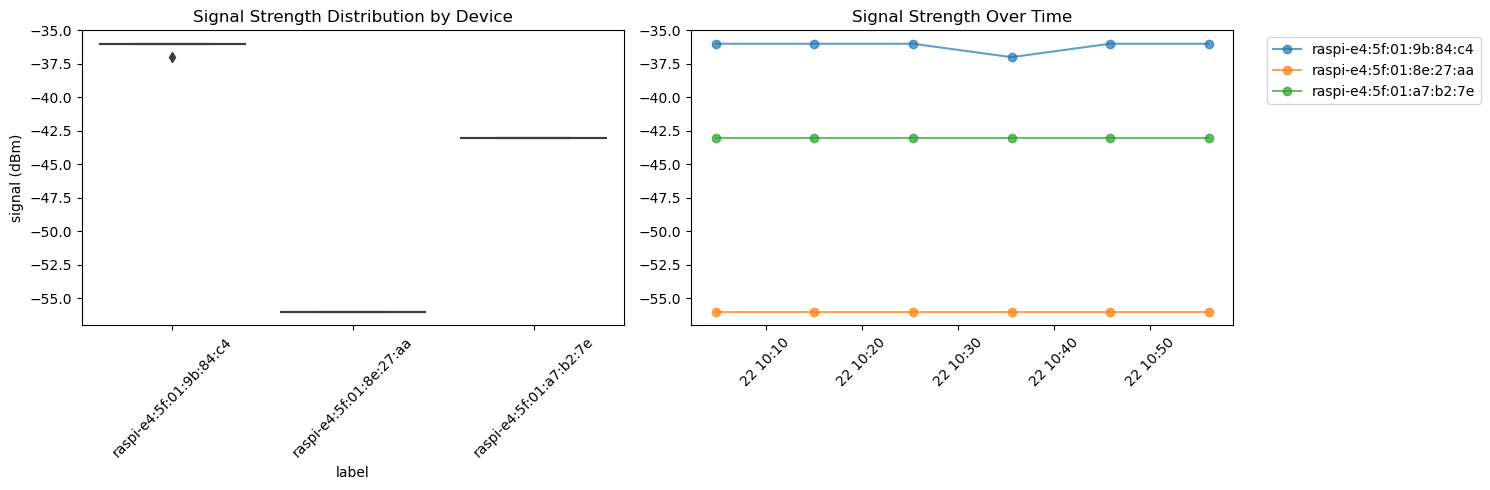


No feature columns found yet. Run feature engineering first.


In [7]:
def perform_eda(df, filtered_data=None):
    """
    Performs comprehensive exploratory data analysis on WiFi statistics data.
    
    Parameters:
    - df: Original DataFrame
    - filtered_data: Optional filtered DataFrame for specific analysis
    """
    # 1. Original DataFrame Analysis
    print("=== Original DataFrame Analysis ===")
    print(f"Shape: {df.shape}")
    print("\nColumns:", df.columns.tolist())
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nSample of first few rows:\n", df.head())

    # 2. Device Analysis
    print("\n=== Unique Devices ===")
    print("Devices:", df['label'].unique())
    print(f"Total unique devices: {df['label'].nunique()}")

    # 3. Time Analysis
    print("\n=== Time Range Analysis ===")
    df['time'] = pd.to_datetime(df['time'])
    print(f"Start date: {df['time'].min()}")
    print(f"End date: {df['time'].max()}")
    print(f"Total time span: {df['time'].max() - df['time'].min()}")

    # 4. Filtered Data Analysis (if provided)
    if filtered_data is not None:
        analyze_filtered_data(filtered_data)

def analyze_filtered_data(filtered_data):
    """Helper function to analyze filtered dataset"""
    print("\n=== Filtered DataFrame Analysis ===")
    filtered_data['time'] = pd.to_datetime(filtered_data['time'])
    
    print(f"Shape: {filtered_data.shape}")
    print("\nColumns:", filtered_data.columns.tolist())
    print("\nData Types:\n", filtered_data.dtypes)
    print("\nMissing Values:\n", filtered_data.isnull().sum())
    
    # Signal Analysis
    print("\n=== Signal Strength Statistics ===")
    print(filtered_data.groupby('label')['signal (dBm)'].describe())
    
    # Time Interval Analysis
    print("\n=== Time Intervals Between Measurements ===")
    filtered_data['time_diff'] = filtered_data.groupby('label')['time'].diff()
    print(filtered_data.groupby('label')['time_diff'].describe())
    
    # Visualizations
    create_visualizations(filtered_data)
    
    # Feature Analysis
    analyze_features(filtered_data)

def create_visualizations(filtered_data):
    """Creates standard visualizations for the filtered data"""
    plt.figure(figsize=(15, 5))
    
    # Signal Distribution
    plt.subplot(121)
    sns.boxplot(data=filtered_data, x='label', y='signal (dBm)')
    plt.xticks(rotation=45)
    plt.title('Signal Strength Distribution by Device')
    
    # Time Series
    plt.subplot(122)
    for label in filtered_data['label'].unique():
        device_data = filtered_data[filtered_data['label'] == label]
        plt.plot(device_data['time'], device_data['signal (dBm)'], 
                label=label, marker='o', linestyle='-', alpha=0.7)
    plt.title('Signal Strength Over Time')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def analyze_features(filtered_data):
    """Analyzes engineered features if they exist"""
    feature_columns = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 
                      'rolling_std_3', 'hour', 'minute']
    existing_features = [col for col in feature_columns if col in filtered_data.columns]
    
    if existing_features:
        print("\n=== Created Features Statistics ===")
        print(filtered_data[existing_features].describe())
        
        # Correlation Analysis
        plt.figure(figsize=(10, 8))
        correlation_matrix = filtered_data[['signal (dBm)'] + existing_features].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo feature columns found yet. Run feature engineering first.")

# Execute the analysis
perform_eda(df, filtered_data)

In [30]:
df['hour'] = pd.to_datetime(df['time']).dt.hour
print("Time Column vs Extracted Hour:")
print(df[['time', 'hour']].head(100))

Time Column vs Extracted Hour:
                         time  hour
0  2024-02-13 00:46:21.750007     0
1  2024-02-13 00:56:37.584578     0
2  2024-02-13 01:07:13.715263     1
3  2024-02-13 01:17:39.679114     1
4  2024-02-13 01:28:05.725746     1
5  2024-02-13 01:38:31.621677     1
6  2024-02-13 01:48:57.696902     1
7  2024-02-13 01:59:13.364732     1
8  2024-02-13 02:09:29.092882     2
9  2024-02-13 02:19:44.893283     2
10 2024-02-13 02:30:10.978906     2
11 2024-02-13 02:40:26.739441     2
12 2024-02-13 02:50:42.482783     2
13 2024-02-13 03:00:58.185842     3
14 2024-02-13 03:11:24.198325     3
15 2024-02-13 03:21:39.849323     3
16 2024-02-13 03:32:05.802359     3
17 2024-02-13 03:42:31.739830     3
18 2024-02-13 03:52:57.669780     3
19 2024-02-13 04:03:23.664623     4
20 2024-02-13 04:13:39.503259     4
21 2024-02-13 04:24:05.402050     4
22 2024-02-13 04:34:31.498404     4
23 2024-02-13 04:44:57.382945     4
24 2024-02-13 04:55:23.319750     4
25 2024-02-13 05:05:38.947812    

In [29]:
import pandas as pd
wifistats_df['time'] = pd.to_datetime(wifistats_df['time'])
device_label = 'raspi-e4:5f:01:84:8c:99'
date_of_interest = '2024-02-13'
filtered_df = wifistats_df[(wifistats_df['label'] == device_label) & 
                           (wifistats_df['time'].dt.date == pd.to_datetime(date_of_interest).date())]
result_df = filtered_df[['label', 'time', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)']]
print(result_df)

                           label                       time  \
0        raspi-e4:5f:01:84:8c:99 2024-02-13 00:46:21.750007   
73       raspi-e4:5f:01:84:8c:99 2024-02-13 00:56:37.584578   
114      raspi-e4:5f:01:84:8c:99 2024-02-13 01:07:13.715263   
174      raspi-e4:5f:01:84:8c:99 2024-02-13 01:17:39.679114   
262      raspi-e4:5f:01:84:8c:99 2024-02-13 01:28:05.725746   
329      raspi-e4:5f:01:84:8c:99 2024-02-13 01:38:31.621677   
383      raspi-e4:5f:01:84:8c:99 2024-02-13 01:48:57.696902   
452      raspi-e4:5f:01:84:8c:99 2024-02-13 01:59:13.364732   
530      raspi-e4:5f:01:84:8c:99 2024-02-13 02:09:29.092882   
592      raspi-e4:5f:01:84:8c:99 2024-02-13 02:19:44.893283   
623      raspi-e4:5f:01:84:8c:99 2024-02-13 02:30:10.978906   
727      raspi-e4:5f:01:84:8c:99 2024-02-13 02:40:26.739441   
790      raspi-e4:5f:01:84:8c:99 2024-02-13 02:50:42.482783   
838      raspi-e4:5f:01:84:8c:99 2024-02-13 03:00:58.185842   
887      raspi-e4:5f:01:84:8c:99 2024-02-13 03:11:24.19

# REGRESSION HERE
Look atthe data: I picked this device: raspi-e4:5f:01:84:8c:99' and the day 2024-02-13 as an example and printed and plotted the data. Based on this data, and the variables in the wifistats data we can apply some regression modeling which uses time as a feature B1 (we will add one or two more features to this model) to predict the tx_bitrate (MBit/s) and rx_bitrate (MBit/s) for the device. 

In [28]:
import pandas as pd
wifistats_df['time'] = pd.to_datetime(wifistats_df['time'])
device_label = 'raspi-e4:5f:01:84:8c:99'
date_of_interest = '2024-02-13'
filtered_df = wifistats_df[(wifistats_df['label'] == device_label) & 
                           (wifistats_df['time'].dt.date == pd.to_datetime(date_of_interest).date())]
result_df = filtered_df[['label', 'time', 'tx_bitrate (MBit/s)', 'rx_bitrate (MBit/s)']]
result_df.head()

,label,time,tx_bitrate (MBit/s),rx_bitrate (MBit/s)
0,raspi-e4:5f:01:84:8c:99,2024-02-13 00:46:21.750007,200.0,150.0
73,raspi-e4:5f:01:84:8c:99,2024-02-13 00:56:37.584578,200.0,150.0
114,raspi-e4:5f:01:84:8c:99,2024-02-13 01:07:13.715263,200.0,150.0
174,raspi-e4:5f:01:84:8c:99,2024-02-13 01:17:39.679114,200.0,121.5
262,raspi-e4:5f:01:84:8c:99,2024-02-13 01:28:05.725746,180.0,121.5


/var/folders/bm/dh8z1y295zx4278nbfwzcvz40000gn/T/ipykernel_31319/2159772311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['time'] = pd.to_datetime(result_df['time'])


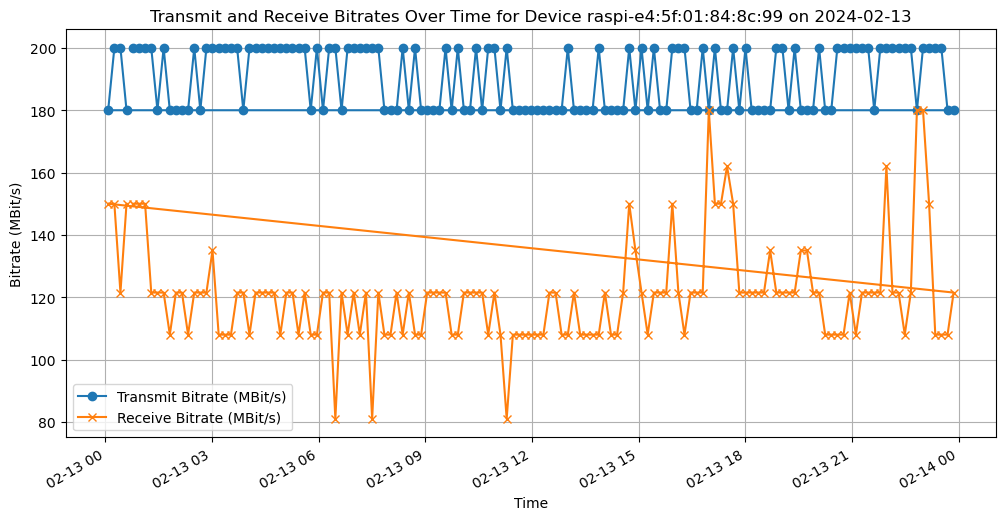

In [27]:
import matplotlib.pyplot as plt
result_df['time'] = pd.to_datetime(result_df['time'])
plt.figure(figsize=(12, 6))
plt.plot(result_df['time'], result_df['tx_bitrate (MBit/s)'], label='Transmit Bitrate (MBit/s)', marker='o')
plt.plot(result_df['time'], result_df['rx_bitrate (MBit/s)'], label='Receive Bitrate (MBit/s)', marker='x')
plt.xlabel('Time')
plt.ylabel('Bitrate (MBit/s)')
plt.title('Transmit and Receive Bitrates Over Time for Device raspi-e4:5f:01:84:8c:99 on 2024-02-13')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()

In [24]:
print("Unique labels:", filtered_df['label'].unique())
print("Date range:", filtered_df['time'].dt.date.unique())

Unique labels: ['raspi-e4:5f:01:84:8c:99']
Date range: [datetime.date(2024, 2, 13)]
